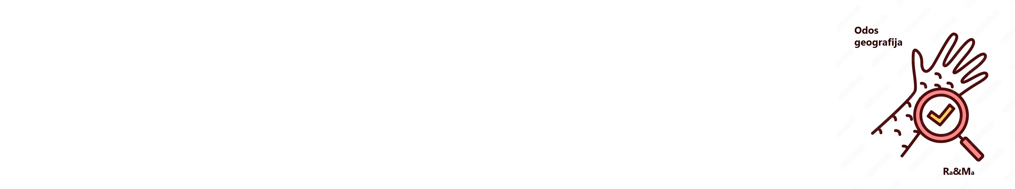

# Odos pigmentinių darinių klasifikavimas 

## Duomenys

Duomenų rinkinį sudaro **10 015** dermatoskopinių vaizdų ir apima visas svarbias pigmentinių pažeidimų kategorijas. Duomenų šaltinis - **Medical University of Vienna**.
Duomenys išleisti mašininio mokymosi tikslais ir yra viešai prieinami **ISIC archyve**. ISIC (angl. - *The International Skin Imaging Collaboration*) -  Tarptautinė odos vaizdavimo bendruomenė. ISIC yra akademinės bendruomenės ir pramonės partnerystė, skirta palengvinti skaitmeninių odos vaizdų taikymą ir padėti sumažinti mirtingumą nuo melanomos.
​
Pigmentinių pažeidimų kategorijos:
​
- aktininė keratozė ir intraepitelinė karcinoma / Boweno liga (AKIEC),
- **bazinių ląstelių karcinoma (BCC)**,
- gerybiniai į keratozę panašūs pažeidimai (seborėjinė keratozė, plokščioji keratozė) (BKL),
- dermatofibroma (DF),
- **melanoma (MEL)**,
- melanocytiniai apgamai (NV)
- kraujagyslių pažeidimai (angioma, angiokeratoma, kt.) (VASC).

## Aplinkos paruošimas

In [143]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras import layers
from keras import models
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax,RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential



from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=7, restore_best_weights=True)

import time
import warnings
warnings.filterwarnings("ignore")

In [144]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(acc,     'bo', color='blue', label='Training acc')
    plt.plot(val_acc, 'b',  color='red', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylim([0, 1])
    plt.legend()
    plt.figure()

    plt.plot(loss, 'bo', color='blue', label='Training loss')
    plt.plot(val_loss, 'b', color='red', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylim([0, 2])
    plt.legend()
    plt.figure()
    plt.show()

### Vaizdų nuskaitymas

(450, 600, 3)


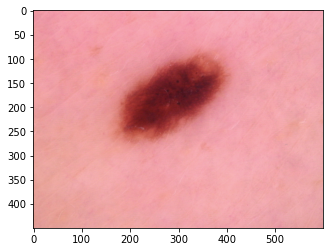

In [128]:
fpath = r'F:/MG/Data/images/ISIC_0024339.jpg'
img = plt.imread(fpath)
print(img.shape)
plt.imshow(img)

### Kategorijų kodų nuskaitymas iš *csv* failo 

In [129]:
df = pd.read_csv(r'F:/MG/Data/GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [130]:
df['image'] = df['image'].apply(lambda x: x+ '.jpg')
print(df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [131]:
labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list = []
for i in range (len(df)):
    row = list(df.iloc[i])
    del row[0]
    index = np.argmax(row)
    label = labels[index]
    label_list.append(label)
df['label'] = label_list
df = df.drop(labels, axis = 1)
print (df.head())

              image label
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL


In [132]:
print (df['label'].value_counts())
print ('original number of classes: ', len(df['label'].unique())) 

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64
original number of classes:  7


Pašalinsim VASC (kraujagyslių pažeidimai )  ir DF (dermatofibroma):

In [133]:
options = ['VASC', 'DF']
df_5 = df[~df.label.isin(options)]
print (df_5.head())

              image label
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL


In [134]:
print (df_5['label'].value_counts())
print ('original number of classes: ', len(df_5['label'].unique())) 

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
Name: label, dtype: int64
original number of classes:  5


In [135]:
df = df_5

## Duomenų rinkinio skaidymas į *train*, *test* and *valid*

In [136]:
train_df, test_valid_df = train_test_split(df,            train_size=0.9, shuffle=True, random_state=42)
valid_df, test_df       = train_test_split(test_valid_df, train_size=0.5, shuffle=True, random_state=42)

print('train_df length: ', len(train_df))
print('valid_df length: ', len(valid_df)) 
print('test_df length:  ', len(test_df))  
print('')
print (train_df['label'].value_counts())
print (valid_df['label'].value_counts())
print (test_df['label'].value_counts())

train_df length:  8782
valid_df length:  488
test_df length:   488

NV       6036
BKL      1006
MEL       984
BCC       461
AKIEC     295
Name: label, dtype: int64
NV       330
MEL       65
BKL       44
BCC       28
AKIEC     21
Name: label, dtype: int64
NV       339
MEL       64
BKL       49
BCC       25
AKIEC     11
Name: label, dtype: int64


### train_df rinkinio balansavimas

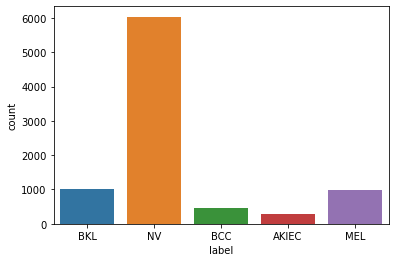

In [137]:
import seaborn as sns
sns.countplot(x=train_df["label"]);

In [138]:
size = 300 
samples = []
group = train_df.groupby('label')
for label in train_df['label'].unique():
    lgroup = group.get_group(label)
    count = int(lgroup['label'].value_counts())    
    if count >= size:
        sample = lgroup.sample(size, axis=0)        
    else:        
        sample = lgroup.sample(frac=1, axis=0)
    samples.append(sample) 
train_df = pd.concat(samples, axis=0).reset_index(drop=True)
print (len(train_df))
print ('final number of classes: ', len(train_df['label'].unique()))       
print (train_df['label'].value_counts())  

1495
final number of classes:  5
BKL      300
NV       300
BCC      300
MEL      300
AKIEC    295
Name: label, dtype: int64


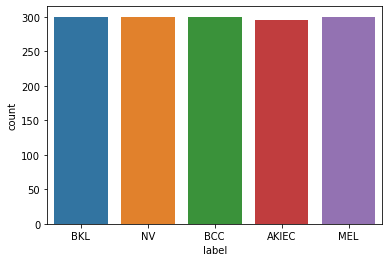

In [139]:
import seaborn as sns
sns.countplot(x=train_df["label"]);

## Generatorių *train*, *test* ir *valid* sukurimas:

In [164]:
img_dir = r'F:/MG/Data/images'
height = 224  
width = 224  
channels = 3  
batch_size = 20  
img_shape = (height, width, channels)
img_size = (height, width)

In [165]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
) 

test_datagen = ImageDataGenerator(
     rescale=1./255
)
valid_datagen = ImageDataGenerator(
     rescale=1./255
)

train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, directory = img_dir, x_col = 'image', y_col = 'label', target_size = img_size, batch_size = batch_size, class_mode = 'categorical')
test_gen  = test_datagen.flow_from_dataframe (dataframe = test_df,  directory = img_dir, x_col = 'image', y_col = 'label', target_size = img_size, batch_size = batch_size, class_mode = 'categorical')                               
valid_gen = valid_datagen.flow_from_dataframe(dataframe = valid_df, directory = img_dir, x_col = 'image', y_col = 'label', target_size = img_size, batch_size = batch_size, class_mode = 'categorical') 
                                  

classes = list(train_gen.class_indices.keys())
class_count = len(classes)

Found 1495 validated image filenames belonging to 5 classes.
Found 488 validated image filenames belonging to 5 classes.
Found 488 validated image filenames belonging to 5 classes.


In [166]:
print(classes)
print(class_count)

['AKIEC', 'BCC', 'BKL', 'MEL', 'NV']
5


{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'MEL': 3, 'NV': 4}


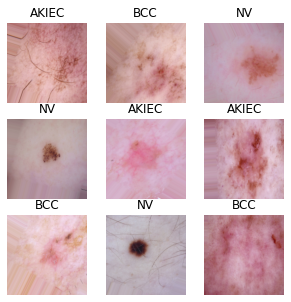

In [85]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    print(test_dict)  
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(5, 5))
    length=len(labels)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        image=images[i] #/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

## CNN modeliai

### CNN tinklo mokymas nuo nulio (58%)

In [205]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape = img_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [206]:
# model.summary()

In [207]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=7, restore_best_weights=True)

In [208]:
model.compile(RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [209]:
%%time
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=74, 
    epochs=30, 
    validation_data=valid_gen,
    callbacks = [early_stopping_monitor])

Epoch 1/30
74/74 [==============================] - 29s 392ms/step - loss: 4.8534 - acc: 0.2027 - val_loss: 5.5817 - val_acc: 0.0902
Epoch 2/30
74/74 [==============================] - 30s 401ms/step - loss: 4.8954 - acc: 0.2020 - val_loss: 5.5817 - val_acc: 0.0902
Epoch 3/30
74/74 [==============================] - 29s 389ms/step - loss: 4.8912 - acc: 0.2027 - val_loss: 5.5817 - val_acc: 0.0902
Epoch 4/30
74/74 [==============================] - 29s 391ms/step - loss: 4.8954 - acc: 0.2020 - val_loss: 5.5817 - val_acc: 0.0902
Epoch 5/30
74/74 [==============================] - 31s 423ms/step - loss: 4.9037 - acc: 0.2007 - val_loss: 5.5817 - val_acc: 0.0902
Epoch 6/30
74/74 [==============================] - 30s 401ms/step - loss: 4.8995 - acc: 0.2014 - val_loss: 5.5817 - val_acc: 0.0902
Epoch 7/30
74/74 [==============================] - 28s 383ms/step - loss: 4.8996 - acc: 0.2014 - val_loss: 5.5817 - val_acc: 0.0902
Epoch 8/30
74/74 [==============================] - 29s 391ms/step - 

In [210]:
test_loss, test_acc = model.evaluate(test_gen)
test_acc

25/25 [==============================] - 3s 139ms/step - loss: 5.5188 - acc: 0.1004


0.10040983557701111

In [189]:
model.save('C:/Users/girza/OneDrive/Documents/SDA/00-Final project/convnet_from_scratch.h5')

In [23]:
# model = tf.keras.models.load_model('C:/Users/girza/OneDrive/Documents/SDA/00-Final project/model_sequential_1.h5')

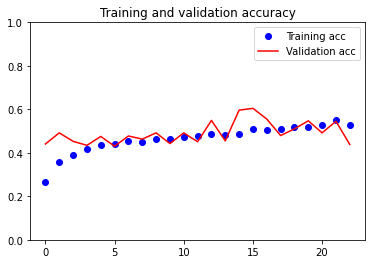

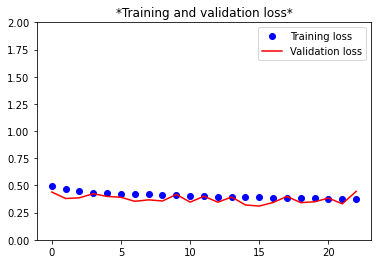

<Figure size 432x288 with 0 Axes>

In [202]:
plot_history(history)   

## Iš anksto paruoštų CNN modelių panaudojimas

### Modelis VGG16

#### Požymių išskyrimas su duomenų prapletimu (*feature extraction with data augmentation*) (62%)

In [44]:
from keras.applications import VGG16

In [45]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

In [46]:
# conv_base.summary()

In [47]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [48]:
# model.summary()

In [49]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [50]:
conv_base.trainable = False

In [51]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [53]:
model.compile(RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [60]:
%%time
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=74, 
    epochs=30, 
    validation_data=valid_gen,
    callbacks = [early_stopping_monitor])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
74/74 [==============================] - 91s 1s/step - loss: 0.4924 - acc: 0.2895 - val_loss: 0.4865 - val_acc: 0.3791
Epoch 2/30
74/74 [==============================] - 86s 1s/step - loss: 0.4629 - acc: 0.4095 - val_loss: 0.4111 - val_acc: 0.6209
Epoch 3/30
74/74 [==============================] - 85s 1s/step - loss: 0.4468 - acc: 0.4393 - val_loss: 0.4152 - val_acc: 0.5840
Epoch 4/30
74/74 [==============================] - 87s 1s/step - loss: 0.4340 - acc: 0.4766 - val_loss: 0.3981 - val_acc: 0.5861
Epoch 5/30
74/74 [==============================] - 83s 1s/step - loss: 0.4231 - acc: 0.4902 - val_loss: 0.4234 - val_acc: 0.5697
Epoch 6/30
74/74 [==============================] - 83s 1s/step - loss: 0.4190 - acc: 0.4922 - val_loss: 0.4206 - val_acc: 0.5553
Epoch 7/30
74/74 [==============================] - 82s 1s/step - loss: 0.4145 - acc: 0.4888 - val_loss: 0.4138 - val_acc: 0.5574
Epoch 8/30
74/

In [61]:
test_loss, test_acc = model.evaluate(test_gen)
test_acc

25/25 [==============================] - 20s 788ms/step - loss: 0.3532 - acc: 0.6209


0.6209016442298889

In [62]:
model.save('C:/Users/girza/OneDrive/Documents/SDA/00-Final project/model_VGG16_62.h5')

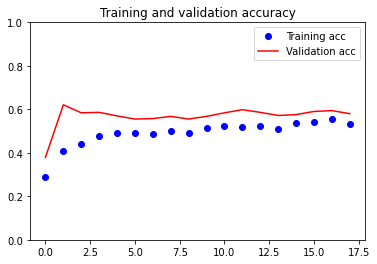

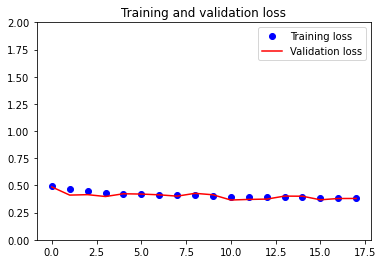

<Figure size 432x288 with 0 Axes>

In [66]:
plot_history(history) 

#### Pakartotinas modelio mokymasis (*fine-tuning*) (66%)

Norint iš naujo išmokyti tinklą, reikia atlikti šiuos veiksmus:
1. Pridėti savo tinklą prie apmokyto bazinio tinklo.
2. Užšaldyti pagrindinį tinklą.
3. Treniruoti pridėtą dalį. (1-3 p. jau atlikti).


4. Atjungti kelis pagrindinio tinklo sluoksnius.
5. Treniruoti sluoksnius kartu su pridėta dalimi.

In [67]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [68]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [69]:
history = model.fit_generator(
          train_gen,
          steps_per_epoch=74,
          epochs=30,
          validation_data=valid_gen,
          callbacks = [early_stopping_monitor])

Epoch 1/30
74/74 [==============================] - 95s 1s/step - loss: 0.3892 - acc: 0.5338 - val_loss: 0.4731 - val_acc: 0.5000
Epoch 2/30
74/74 [==============================] - 94s 1s/step - loss: 0.3697 - acc: 0.5586 - val_loss: 0.4328 - val_acc: 0.5574
Epoch 3/30
74/74 [==============================] - 94s 1s/step - loss: 0.3573 - acc: 0.5837 - val_loss: 0.4085 - val_acc: 0.5922
Epoch 4/30
74/74 [==============================] - 96s 1s/step - loss: 0.3544 - acc: 0.5776 - val_loss: 0.3848 - val_acc: 0.6045
Epoch 5/30
74/74 [==============================] - 96s 1s/step - loss: 0.3419 - acc: 0.6034 - val_loss: 0.3818 - val_acc: 0.5943
Epoch 6/30
74/74 [==============================] - 96s 1s/step - loss: 0.3376 - acc: 0.6081 - val_loss: 0.3481 - val_acc: 0.6332
Epoch 7/30
74/74 [==============================] - 96s 1s/step - loss: 0.3354 - acc: 0.6149 - val_loss: 0.3542 - val_acc: 0.6250
Epoch 8/30
74/74 [==============================] - 95s 1s/step - loss: 0.3255 - acc: 0.62

In [70]:
test_loss, test_acc = model.evaluate(test_gen)
test_acc

25/25 [==============================] - 19s 777ms/step - loss: 0.3167 - acc: 0.6598


0.6598360538482666

In [71]:
model.save('C:/Users/girza/OneDrive/Documents/SDA/00-Final project/model_VGG16_ft_66.h5')

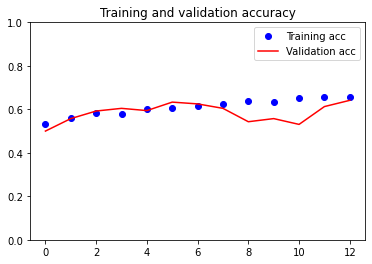

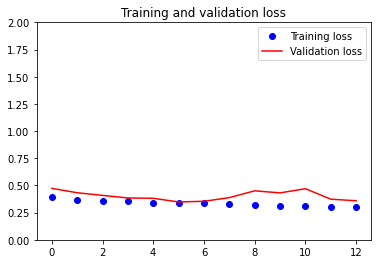

<Figure size 432x288 with 0 Axes>

In [73]:
plot_history(history)

### MobileNet

In [97]:
from keras.applications import MobileNet

In [116]:
conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=img_shape)

In [117]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [118]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 85


In [119]:
conv_base.trainable = False

In [120]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [121]:
model.compile(RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [104]:
%%time
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=74, 
    epochs=30, 
    validation_data=valid_gen,
    callbacks = [early_stopping_monitor])

Epoch 1/30
74/74 [==============================] - 30s 403ms/step - loss: 0.4781 - acc: 0.4542 - val_loss: 0.5222 - val_acc: 0.4221
Epoch 2/30
74/74 [==============================] - 29s 394ms/step - loss: 0.2113 - acc: 0.7776 - val_loss: 0.4033 - val_acc: 0.6168
Epoch 3/30
74/74 [==============================] - 30s 406ms/step - loss: 0.0988 - acc: 0.9281 - val_loss: 0.4074 - val_acc: 0.5881
Epoch 4/30
74/74 [==============================] - 28s 385ms/step - loss: 0.0452 - acc: 0.9756 - val_loss: 0.4385 - val_acc: 0.5943
Epoch 5/30
74/74 [==============================] - 29s 393ms/step - loss: 0.0181 - acc: 0.9980 - val_loss: 0.4857 - val_acc: 0.5656
Epoch 6/30
74/74 [==============================] - 29s 397ms/step - loss: 0.0085 - acc: 0.9986 - val_loss: 0.5186 - val_acc: 0.5779
Epoch 7/30
74/74 [==============================] - 29s 388ms/step - loss: 0.0035 - acc: 0.9993 - val_loss: 0.4347 - val_acc: 0.6393
Epoch 8/30
74/74 [==============================] - 29s 396ms/step - 

In [105]:
test_loss, test_acc = model.evaluate(test_gen)
test_acc

25/25 [==============================] - 6s 232ms/step - loss: 0.3677 - acc: 0.7357


0.7356557250022888

In [107]:
model.save('C:/Users/girza/OneDrive/Documents/SDA/00-Final project/model_MobileNet_74.h5')

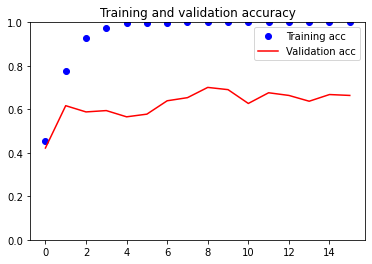

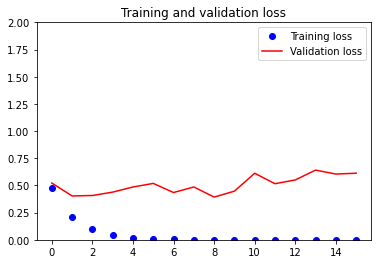

<Figure size 432x288 with 0 Axes>

In [108]:
plot_history(history) 

### EfficientNetB1

In [156]:
conv_base = tf.keras.applications.EfficientNetB1(weights="imagenet", 
                                     include_top=False, 
                                     input_shape=img_shape, 
                                     pooling='max') 

In [157]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [158]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 303


In [159]:
conv_base.trainable = False

In [160]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [161]:
model.compile(RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [162]:
%%time
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=74, 
    epochs=30, 
    validation_data=valid_gen,
    callbacks = [early_stopping_monitor])

Epoch 1/30
74/74 [==============================] - 64s 866ms/step - loss: 0.8470 - acc: 0.2508 - val_loss: 0.5190 - val_acc: 0.4447
Epoch 2/30
74/74 [==============================] - 63s 851ms/step - loss: 0.6217 - acc: 0.3302 - val_loss: 0.5172 - val_acc: 0.4160
Epoch 3/30
74/74 [==============================] - 63s 851ms/step - loss: 0.5607 - acc: 0.3708 - val_loss: 0.4993 - val_acc: 0.4488
Epoch 4/30
74/74 [==============================] - 63s 857ms/step - loss: 0.5416 - acc: 0.3736 - val_loss: 0.4084 - val_acc: 0.5594
Epoch 5/30
74/74 [==============================] - 62s 839ms/step - loss: 0.4973 - acc: 0.4210 - val_loss: 0.4640 - val_acc: 0.4959
Epoch 6/30
74/74 [==============================] - 64s 865ms/step - loss: 0.4746 - acc: 0.4325 - val_loss: 0.4510 - val_acc: 0.5266
Epoch 7/30
74/74 [==============================] - 62s 842ms/step - loss: 0.4615 - acc: 0.4407 - val_loss: 0.4325 - val_acc: 0.5307
Epoch 8/30
74/74 [==============================] - 64s 861ms/step - 

In [163]:
test_loss, test_acc = model.evaluate(test_gen)
test_acc

25/25 [==============================] - 15s 591ms/step - loss: 0.4048 - acc: 0.5779


0.5778688788414001

In [ ]:
model.save('C:/Users/girza/OneDrive/Documents/SDA/00-Final project/model_MobileNet_74.h5')

In [ ]:
plot_history(history) 

In [167]:
EfficientNetB1_base = tf.keras.applications.EfficientNetB1(weights="imagenet", 
                                     include_top=False, 
                                     input_shape=img_shape, 
                                     pooling='max') 
x = EfficientNetB1_base.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(5, activation='softmax')(x)
model=Model(inputs=EfficientNetB1_base.input, outputs=output)

In [168]:
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [169]:
%%time
history = model.fit_generator(
          train_gen,
          steps_per_epoch=74,
          epochs=30,
          validation_data=valid_gen,
          callbacks = [early_stopping_monitor])

Epoch 1/30
74/74 [==============================] - 317s 4s/step - loss: 8.8900 - accuracy: 0.3966 - val_loss: 10.4535 - val_accuracy: 0.0430
Epoch 2/30
15/74 [=====>........................] - ETA: 3:50 - loss: 7.7777 - accuracy: 0.5600

KeyboardInterrupt: 

## Apibendrinant

-	Konvoliuciniai neuroniniai tinklai (CNN) yra geriausias mašininio mokymosi modelių tipas vaizdų atpažinimo problemoms spręsti. Tinklą galima išmokyti nuo nulio naudojant mažą duomenų rinkinį ir gauti patenkinamą rezultatą. 
-	Kai duomenų kiekis yra nedidelis, persimokymas tampa pagrindine problema. Duomenų praplėtimas (*data augmentation*) yra veiksminga priemonė kovoti su persimokymu dirbant su vaizdais. 
-	Jau esamus CNN nesudėtinga pakartotinai panaudoti turimiems duomenims naudojant požymių išskyrimą (*feature extraction*). Ši technika ypač vertinga dirbant su mažais vaizdų rinkiniais.
-	Be požymių išskyrimo, galima naudoti papildomo mokymosi (*fine-tuning*) techniką, kuri prisitaiko prie naujos užduoties.


## Klasifikavimas

In [83]:
def my_predict(model, image_file):
  
  img = keras.preprocessing.image.load_img(image_file, target_size=img_size)
  img_arr = np.expand_dims(img, axis=0) / 255.0
  result = model.predict_classes(img_arr)
  print("Result: %s" % labels[result[0]])


my_predict(model, "F:/MG/Data/images/ISIC_0024314.jpg")

Result: BKL


## Prototipas :)

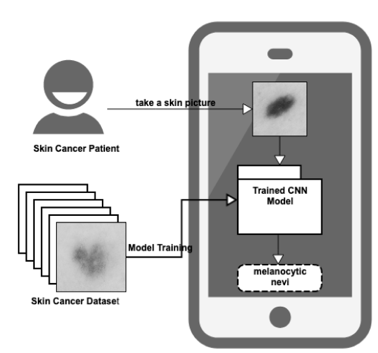

## Naudota literatūra 

1. FRANÇOIS CHOLLET. Deep Learning with Python. 2018

2. ...